In [1]:
import gym
import numpy as np
import tensorflow as tf

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Introduction

Previously, we tried an off-policy model with the <B>Deep-Q Network (DQN)</B> and policy model with the <B>Policy Gradient (PG)</B>. Today, we will implement a new model used to replace <B>Policy Gradient</B> which is <B>Proximal Policy Optimization (PPO)</B>.

This model has been proposed by OpenAI in 2017 (<a href="https://arxiv.org/pdf/1707.06347.pdf">ArXiv Paper 1707.06347</a>). 

The drawback of PG is mainly the robustness a quite important quantity of trials to learn and in addition it may have a learning non stable over time even if the model reaches good score. We saw it on the example with alpha = 1 in PG's Notebook. Before the PPO publication, there were the Trust Region Policy Optimisation which was done for this purpose. The learning was "clipped" to avoid moving too far between 2 updates of Policy Net. This model won't be tried as it is "obsolete" now and more complicated to implement. A nice explanation is available <a href="https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12">here</a>

As we did with previous models, we will try it on a simple environment as a baseline with the Cartpole. 

# Model

The model compared to PG is divided in 2 parts :
<ul>
    <li>A Value Net : Compute the advantage of taking the best action</li>
    <li>A Policy Net : Compute the probability for each action of being the best one</li>
</ul>

Like it is with DQN with fixed Q, we need here also 2 models an Old Policy and a current Policy. Every N steps, the Old Policy will be updated with the latest one. This method is mainly for stability.

In [2]:
class Network:
    def __init__(self, name, sess, temp=0.1):
        self.sess = sess
        self.scope = name
        
        with tf.variable_scope(name):
            self.input = tf.placeholder(dtype=tf.float32, shape=[None, 4], name='obs')

            with tf.variable_scope('policy_net'):
                H1_1 = tf.layers.dense(inputs=self.input, units=20, activation=tf.tanh)
                H1_2 = tf.layers.dense(inputs=H1_1, units=20, activation=tf.tanh)
                H1_3 = tf.layers.dense(inputs=H1_2, units=2, activation=tf.tanh)
                self.actions = tf.layers.dense(inputs=tf.divide(H1_3, temp), units=2, activation=tf.nn.softmax)

            with tf.variable_scope('value_net'):
                H2_1 = tf.layers.dense(inputs=self.input, units=20, activation=tf.tanh)
                H2_2 = tf.layers.dense(inputs=H2_1, units=20, activation=tf.tanh)
                self.value = tf.layers.dense(inputs=H2_2, units=1, activation=None)

            self.action_pred = tf.reshape(tf.multinomial(tf.log(self.actions), num_samples=1), shape=[-1])
            self.action_best = tf.argmax(self.actions, axis=1)

    def get_variables(self):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, self.scope)

    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope)

Now we have our "brain" but the need the agent to control the brain. Mainly this object will contain: 
<ul>
<li>All placeholders to update the Policy Model</li>
<li>A part of graph to update the network</li>
<li>The computation of the loss to update the network in 3 parts</li>
    <ul>
        <li>Clipped Surrogate Objective : 
                $$L^{CLIP}(\theta) = \widehat{E}_{t}[min( r_t(\theta)\widehat{A}_t, clip(r_t(\theta), 1-{\epsilon}, 1+{\epsilon})\widehat{A}_t )]$$
            with 
               \begin{align*}
                    r_t(\theta) &= \frac{{\pi}_{model}(action|state)}{{\pi}_{oldmodel}(action|state)}\\ 
                     &= exp(log({\pi}_{model}(action|state)) - log({\pi}_{oldmodel}(action|state)))
                \end{align*} 
                <br>
        </li>
        <li>Value function Loss : 
            This is the error computed using Bellman's equation :
            $$L^{VF}(\theta) = (V_t(\theta) - (R_t + \gamma * V_{t+1}(\theta)))^2$$
            <br>
        </li>
        <li>Entropy : 
            This loss is an entropy bonus to ensure that we do a sufficient exploration. 
            $$L^{Entropy}(\theta) = {\pi}_{model}(action|state) * log(clip({\pi}_{model}(action|state), 0, 1))$$
            <br>
        </li>
        <li>Final Loss : 
            This loss is a sum of each losses with a certain factor :
            $$ L(\theta) =L^{CLIP}(\theta) - \alpha L^{VF}(\theta) + \beta L^{Entropy}(\theta) $$
            <br>
        </li>
    </ul>
<li>The processing of Trajectories to get the Advantage Estimation</li>
    <ul>
        <li> This is a variation of discounted reward which is :
        $$\widehat{A}_t = \delta_t + \gamma\lambda \sum_{ k=t-1}^{1}\delta_k$$
        with 
        $$\delta_t = R_t + \gamma * V_{t+1}(\theta) - V_t(\theta)$$
        </li>
    </ul>

<li>A part to take actions</li>
</ul>. 

In [3]:
class Agent:
    def __init__(self, sess, gamma=0.95):
        self.Policy = Network('policy', sess)
        self.Old_Policy = Network('old_policy', sess)
        self.gamma = gamma
        self.sess = sess

        # Operation to update the Old Network to Current Policy
        with tf.variable_scope('assign_op'):
            self.assign_ops = []
            for v_old, v in zip(self.Old_Policy.get_trainable_variables(), 
                                self.Policy.get_trainable_variables()):
                self.assign_ops.append(tf.assign(v_old, v))

        # inputs for train_op
        with tf.variable_scope('train_inp'):
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='actions')
            self.rewards = tf.placeholder(dtype=tf.float32, shape=[None], name='rewards')
            self.values_next = tf.placeholder(dtype=tf.float32, shape=[None], name='values_next')
            self.adv_estim = tf.placeholder(dtype=tf.float32, shape=[None], name='adv_estim')

        act_probs = self.Policy.actions
        act_probs_old = self.Old_Policy.actions

        act_probs_loss = tf.reduce_sum(act_probs * tf.one_hot(indices=self.actions, depth=2), axis=1)
        act_probs_old_loss = tf.reduce_sum(act_probs_old * tf.one_hot(indices=self.actions, depth=2), axis=1)
                
        with tf.variable_scope('loss'):
            with tf.variable_scope('Clipped_Surrogate_Objective'):
                ratios = tf.exp(tf.log(act_probs_loss) - tf.log(act_probs_old_loss))               # equivalent to division
                clipped_ratios = tf.clip_by_value(ratios, clip_value_min=0.8, clip_value_max=1.2)  # clip with Epsilon = 0.2
                loss_clip = tf.minimum(tf.multiply(self.adv_estim, ratios), tf.multiply(self.adv_estim, clipped_ratios))
                loss_clip = tf.reduce_mean(loss_clip)

            with tf.variable_scope('Value_Fonction_Error'):
                val_pred = self.Policy.value
                loss_vf = tf.squared_difference(self.rewards + self.gamma * self.values_next, val_pred)
                loss_vf = tf.reduce_mean(loss_vf)

            with tf.variable_scope('Entropy'):
                entropy = -tf.reduce_sum(self.Policy.actions *
                                         tf.log(tf.clip_by_value(self.Policy.actions, 1e-10, 1.0)), axis=1)
                entropy = tf.reduce_mean(entropy, axis=0)

            with tf.variable_scope('global_loss'):
                loss = loss_clip - 1 * loss_vf + 0.01 * entropy

        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        self.train_iter = optimizer.minimize(-loss, var_list=self.Policy.get_trainable_variables())

    def train(self, obs, actions, rewards, v_preds_next, adv):
        self.sess.run([self.train_iter], feed_dict={ self.Policy.input: obs,
                                                     self.Old_Policy.input: obs,
                                                     self.actions: actions,
                                                     self.rewards: rewards,
                                                     self.values_next: v_preds_next,
                                                     self.adv_estim: adv})

    def assign_policy_parameters(self):
        self.sess.run(self.assign_ops)

    def get_advantage_values(self, rewards, v_preds, v_preds_next):
        deltas = rewards + self.gamma * v_preds_next - v_preds
        advantage = np.copy(deltas).astype(dtype=np.float32)
        for t in reversed(range(len(advantage) - 1)):
            advantage[t] = advantage[t] + self.gamma * advantage[t + 1]
        return (advantage - advantage.mean()) / advantage.std()

    def take_action(self, obs, stochastic=True):
        if stochastic:
            return self.sess.run([self.Policy.action_pred, self.Policy.value], feed_dict={self.Policy.input: obs})
        else:
            return self.sess.run([self.Policy.action_best, self.Policy.value], feed_dict={self.Policy.input: obs})

    def get_action_prob(self, obs, session):
        return self.take_action(obs, session)

Now we just have to run the agent in a similar way as PG. After every game, we train the model based on the trajectory and we update the old policy with the new model for the next iteration. In policy gradient, we used to store multiple games, this can be done here too based on the based we want.

In [12]:
result_global = {}
for seed in [0, 42]:
    tf.reset_default_graph()
    tf.set_random_seed(seed = seed)
    np.random.seed(seed)

    ITERATION = 1000
    GAMMA = 0.95

    env = gym.make('CartPole-v0')
    env.seed(0)

    ob_space = env.observation_space

    result = []

    with tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})) as sess:
        PPO = Agent(sess, gamma=GAMMA)
        sess.run(tf.global_variables_initializer())
        obs = env.reset()
        reward = 0
        success_num = 0

        for iteration in range(ITERATION):  # episode
            observations = []
            actions = []
            v_preds = []
            rewards = []
            run_policy_steps = 0
            while True:  # run policy RUN_POLICY_STEPS which is much less than episode length
                run_policy_steps += 1
                obs = np.stack([obs]).astype(dtype=np.float32)  # prepare to feed placeholder Policy.obs

                act, v_pred = PPO.take_action(obs=obs, stochastic=True)

                act = np.asscalar(act)
                v_pred = np.asscalar(v_pred)

                observations.append(obs)
                actions.append(act)
                v_preds.append(v_pred)
                rewards.append(reward)

                next_obs, reward, done, info = env.step(act)

                if done:
                    v_preds_next = v_preds[1:] + [0]  # next state of terminate state has 0 state value
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    obs = next_obs

            print("Episode {} - Length {} - Reward {}\t".format(iteration, run_policy_steps, sum(rewards)), end="\r")
            result.append(run_policy_steps)

            # convert list to numpy array for feeding tf.placeholder
            observations = np.reshape(observations, newshape=[-1, 4])
            actions = np.array(actions).astype(dtype=np.int32)
            rewards = np.array(rewards).astype(dtype=np.float32)
            v_preds = np.array(v_preds).astype(dtype=np.float32)
            v_preds_next = np.array(v_preds_next).astype(dtype=np.float32)

            advantage = PPO.get_advantage_values(rewards=rewards, v_preds=v_preds, v_preds_next=v_preds_next)

            PPO.assign_policy_parameters()

            inp = [observations, actions, rewards, v_preds_next, advantage]

            # train
            for epoch in range(4):
                sample_indices = np.random.randint(low=0, high=observations.shape[0], size=64)  # indices are in [low, high)
                sampled_inp = [np.take(a=a, indices=sample_indices, axis=0) for a in inp]  # sample training data
                PPO.train(obs=sampled_inp[0],
                          actions=sampled_inp[1],
                          rewards=sampled_inp[2],
                          v_preds_next=sampled_inp[3],
                          adv=sampled_inp[4])
    result_global[seed] = result
    print("")

Episode 999 - Length 162 - Reward 160.0	
Episode 999 - Length 9 - Reward 7.0			


# Result

Let's now review the evolution of the number of state played over time.

In [5]:
import matplotlib.pyplot as plt

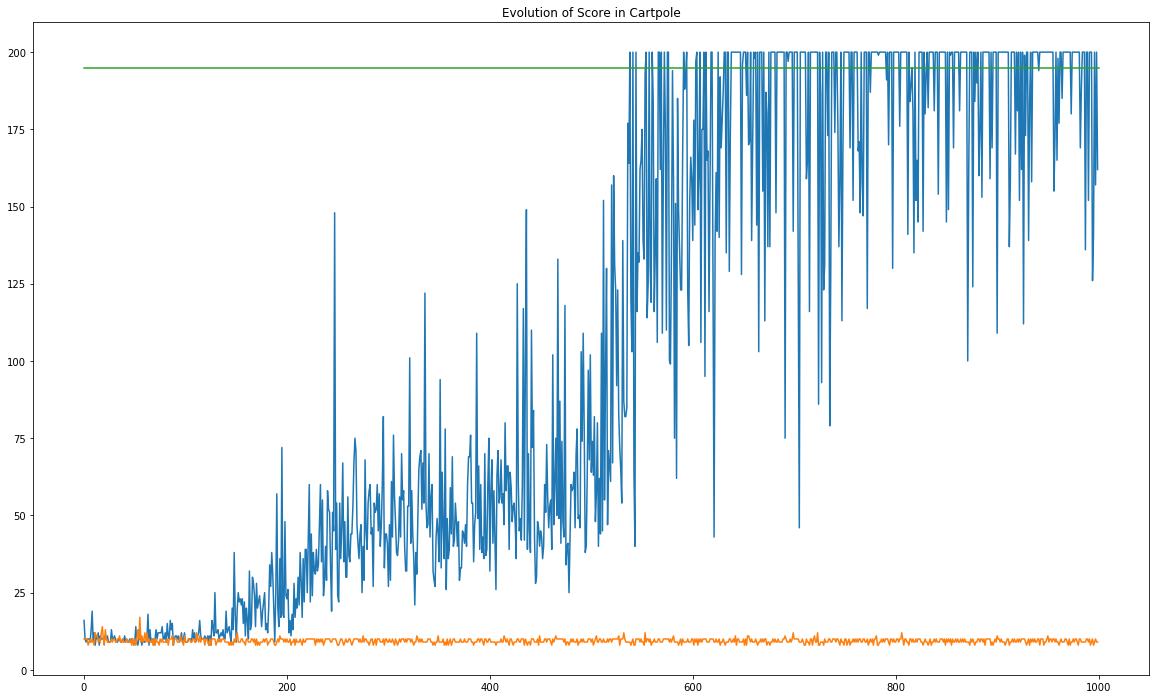

In [10]:
plt.figure(figsize = (20,12))
plt.plot(result_global[0], label="Seed 0 - Works")
plt.plot(result_global[42], label="Seed 42 - Fail")
plt.plot([0, len(result)], [195, 195], label="Target")
plt.title("Evolution of Score in Cartpole based on Tensorflow Seed")
plt.legend()
plt.show()

After multiple trials, I saw that there is huge differences. Sometimes, the model won't be able to solve the puzzle once in 1000 iteration and sometimes, it's a lot as it is now. To have it reproducible, I fixed all seeds but in general, this is a problem. I don't know yet why and how to avoid that (maybe a smaller L/R or using more steps). Nevertheless, the speed to learn to solve this environment is quite impressive. With PG, we needed around 250 iterations steps which include playing 8 games in a row each step so in total 2000 games. Here in few hundreds game, the model was able to solve it in around few hundreds steps (here 500 but sometimes 50 or 800).

# Conclusion

In this Notebook, we explored a model used instead of Policy Gradient. It has some benefit in term of time to learn and stability even if it's not really visible here. Nevertheless, we have to highlight that the training here last very few games. We may improve the stability by using a Learning_rate decay. For this environement, I'wont try to fine tune it but this will be used in a futur project.